# Information Bottleneck theory for Deep Learning

This is a demonstration of the information bottleneck theory for deep learning, introduced by Naftali Tishby. Here I tried to reproduce the main results in their recent paper [Opening the black box of Deep Neural Networks via Information](https://arxiv.org/pdf/1703.00810.pdf).

## Data generation

First, we will generate a very simple dataset for the demonstration. The inputs are vectors of 10 binaries, and the outputs are just single binaries. The inputs could be represented by integers from 0 to 1023 ($=2^{10}-1$). The 1024 possible inputs are divided into 16 groups (each group has 64 numbers), and each integer input $n\in[0,1023]$ belongs to group $i$ if $x\equiv i \pmod{16}$, where $i \in [0,15]$. Each group $i$ is then associated with a random binary number - we build kinda of a distribution over space of possible discrete states (output).

In [2]:
%pylab inline

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from random import randint, seed

# Flag to enable execution on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
print(groups)
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
y_train.shape

(50000, 2)

In [5]:
d={}
for i in y_train:
    d[str(i[0])+', '+str(i[1])] = 0
for i in y_train:
    d[str(i[0])+', '+str(i[1])] += 1
d

{'1.0, 0.0': 24820, '0.0, 1.0': 25180}

For our dataset, the theoritical mutual information between $X$ and $Y$ would be
\begin{align}
I(X;Y) & = \sum_{x\in X, y\in Y}P(x,y)\log\Big(\frac{P(x,y)}{P(x)P(y)}\Big) \\
& = \sum_{x\in X}\Big[P(x,y=0)\log\Big(\frac{P(x,y=0)}{P(x)P(y=0)}\Big) + P(x,y=1)\log\Big(\frac{P(x,y=1)}{P(x)P(y=1)}\Big)\Big] \\
& = 1024 \Big[ \frac{1}{1024}\log\Big(\frac{1/1024}{0.5/1024}\Big) + 0\Big] \\
& = 0.693.
\end{align}
Note that terms with $P(x,y)=0$ are set to $0$ for entropy calculation.

## Neural network

Then we are going to build a fully-connected neural networks with 3 hidden layers, which have 8, 6 and 4 neurons respectively. First let's define a fully-connected layer and a output layer using Tensorflow:

In [6]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes, neg_slope=0.02):
        super(MLP, self).__init__()

        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        for i in range(len(self.num_neurons) - 2):
            self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
            # self.layers.append(nn.LeakyReLU(neg_slope))
            self.layers.append(nn.Tanh())
            #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
            #self.layers['tanh{}'.format(i+1)] = nn.Tanh()
            self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)
            

        self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out


In [7]:
def get_named_layers(net):
    conv2d_idx = 0
    convT2d_idx = 0
    linear_idx = 0
    batchnorm2d_idx = 0
    named_layers = {}
    for mod in net.modules():
        if isinstance(mod, torch.nn.Conv2d):
            layer_name = 'Conv2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            conv2d_idx += 1
        elif isinstance(mod, torch.nn.ConvTranspose2d):
            layer_name = 'ConvT2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            convT2d_idx += 1
        elif isinstance(mod, torch.nn.BatchNorm2d):
            layer_name = 'BatchNorm2D{}_{}'.format(
                batchnorm2d_idx, mod.num_features)
            named_layers[layer_name] = mod
            batchnorm2d_idx += 1
        elif isinstance(mod, torch.nn.Linear):
            layer_name = 'Linear{}_{}-{}'.format(
                linear_idx, mod.in_features, mod.out_features
            )
            named_layers[layer_name] = mod
            linear_idx += 1
    return named_layers

def accuracy(predictions, targets):
    accuracy = (predictions.argmax(dim=1) == targets.argmax(dim=1)).type(torch.FloatTensor).mean().item()
    return accuracy

In [8]:
num_epochs = 2000
dnn_hidden_units = [16, 12, 8, 6, 4]
dnn_input_units = x_train.shape[1]
dnn_output_units = y_train.shape[1]
eval_freq = 100

MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
get_named_layers(MLP_object)
#MLP_object.parameters()

{'Linear0_10-16': Linear(in_features=10, out_features=16, bias=True),
 'Linear1_16-12': Linear(in_features=16, out_features=12, bias=True),
 'Linear2_12-8': Linear(in_features=12, out_features=8, bias=True),
 'Linear3_8-6': Linear(in_features=8, out_features=6, bias=True),
 'Linear4_6-4': Linear(in_features=6, out_features=4, bias=True),
 'Linear5_4-2': Linear(in_features=4, out_features=2, bias=True)}

In [11]:
def train():

    MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(MLP_object.parameters(), lr=0.1)#, momentum=0.2)
    
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device), torch.tensor(y_test, requires_grad=False).to(device)
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}

    start_time = time.time()
    for epoch in range(num_epochs):
        X_train, Y_train = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)
        
        optimizer.zero_grad()
        
        out = MLP_object(X_train.float())
        loss = criterion(out, Y_train.argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            #accuracy_evaluation['train'].append(accuracy(out, y_train))
            #accuracy_evaluation['test'].append(accuracy(MLP_object(X_test), y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(MLP_object(X_test.float()), Y_test), criterion(MLP_object(X_test.float()), Y_test.argmax(dim=1))))
            print('Time after last eval: ', time.time() - start_time)
            print('#'*30,'\n')
train()

##############################
Step -  0
Train: Accuracy - 0.496, Loss - 0.705
Test: Accuracy - 0.496, Loss - 0.703
Time after last eval:  0.07526564598083496
############################## 

##############################
Step -  100
Train: Accuracy - 0.567, Loss - 0.692
Test: Accuracy - 0.569, Loss - 0.692
Time after last eval:  3.6912927627563477
############################## 

##############################
Step -  200
Train: Accuracy - 0.590, Loss - 0.691
Test: Accuracy - 0.591, Loss - 0.691
Time after last eval:  7.097638845443726
############################## 



KeyboardInterrupt: 

## Mutual information

Now we are ready to explore the information bottleneck theory for our network. To estimate the mutual information between all the hidden layers and intput/output layers, we could binned the output activations as stated in the paper  (here we choose 30 bins, the same as in the paper), so that the hidden layer random variables $T_i$ (each $i$ corresponds to one hidden layer) would be discrete. Then, we will be able to estimate the joint distribution $P(X,T_i)$ and $P(T_i,Y)$, and use them to calculate the encoder mutual information (between input $X$ and hidden layer $T_i$)
\begin{equation}
    I(X;T_i) = \sum_{x\in X, t\in T_i}P(x,t)\log\Big(\frac{P(x,t)}{P(x)P(t)}\Big)
\end{equation}

and decoder mutual information (between hidden layer $T_i$ and desired output $Y$, note that it is not the model output $\widehat{Y}$)
\begin{equation}
    I(T_i;Y) = \sum_{t\in T_i, y\in Y}P(t,y)\log\Big(\frac{P(t,y)}{P(t)P(y)}\Big).
\end{equation}

In [9]:
from collections import Counter

def calc_mutual_information(hidden):
    n_neurons = hidden.shape[1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(X;T)
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden.data.numpy())
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list




#Neural approximation of MI starts here
# Auxiliary network for mutual information estimation
class MIEstimator(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator, self).__init__()
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )
    
    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        pos = self.net(torch.cat([x1, x2], 1)) #Positive Samples 
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1)) #Predictions for shuffled (negative) samples from p(z1)p(z2)
        #breakpoint()
        return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1

We are now able to estimate the mutual information while training the network. We'll save the mutual information for later use.

In [11]:
from torch.optim import Adam
from torch.nn.functional import softplus
from collections import OrderedDict
from data_utils import ExponentialScheduler

# Defining the schedule for the update of the hyper-parameter over time
beta_scheduler = ExponentialScheduler(start_value=1e-3, end_value=1, n_iterations=100, start_iteration=50)


num_epochs = 2000
dnn_hidden_units = [10, 8, 6, 4]
x_dim = dnn_input_units = x_train.shape[1]
y_dim = dnn_output_units = y_train.shape[1]
z_dim = 4
eval_freq = 1
beta = 0.01

def get_hidden_layers(net, names, input_tensor):
    with torch.no_grad():
        #hidden_layers_output = {}
        hidden_layers_output = []
        for name in names:
#             hidden_layers_output[name] = net(input_tensor.float(), exitLayer=name).data.numpy()
            hidden_layers_output.append(net(input_tensor.float(), exitLayer=name))#.data.numpy())
    return hidden_layers_output

# train the neural network and obtain mutual information
def train_with_mi(x_train, y_train, x_test, y_test):
    t_names = ['Linear0', 'Linear1', 'Linear2', 'Linear3']
    mi_xt_all = []; mi_ty_all = []; epochs = []
    
    MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    mi_estimator_X = MIEstimator(x_dim, z_dim) 
    mi_estimator_Y = MIEstimator(z_dim, y_dim)
    print(get_named_layers(MLP_object))

    criterion = nn.CrossEntropyLoss()
    
    #optimizer = optim.SGD(MLP_object.parameters(), lr=0.1)#, momentum=0.2)

    optimizer = Adam([
    {'params': MLP_object.parameters(), 'lr':1e-1},
#     {'params': encoder_v_2.parameters(), 'lr':1e-4}, # There is only one encoder in this example
    {'params': mi_estimator_X.parameters(), 'lr':1e-2},
    #{'params': mi_estimator_Y.parameters(), 'lr':1e-4},
])
    
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device).float(), torch.tensor(y_test, requires_grad=False).to(device)
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}
    start_time = time.time()
    for epoch in range(num_epochs):
        
        X_train, Y_train = torch.from_numpy(x_train).to(device).float(), torch.from_numpy(y_train).to(device)
        encoding = get_hidden_layers(MLP_object, t_names, X_train)
        mi_gradient_X, mi_estimation_X = mi_estimator_X(X_train, encoding[-1])
        mi_gradient_X = mi_gradient_X.mean()
        mi_estimation_X = mi_estimation_X.mean()

#         mi_gradient_Y, mi_estimation_Y = mi_estimator_Y(encoding[-1], Y_train.float())
#         mi_gradient_Y = mi_gradient_Y.mean()
#         mi_estimation_Y = mi_estimation_Y.mean()
        
        beta = beta_scheduler(epoch)
        
        optimizer.zero_grad()
        out =  MLP_object(X_train.float())
        loss = criterion(out, Y_train.argmax(dim=1)) - beta * mi_gradient_X
        #loss_mi = 
        loss.backward()
        optimizer.step()
                
                
            

        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            mi_xt, mi_ty = get_mutual_information(encoding)
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            epochs.append(epoch)
            #accuracy_evaluation['train'].append(accuracy(out, y_train))
            #accuracy_evaluation['test'].append(accuracy(MLP_object(X_test), y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(MLP_object(X_test), Y_test), criterion(MLP_object(X_test), Y_test.argmax(dim=1))))
            print('I(X, T) - ', mi_xt)
            print('I(T, Y) - ', mi_ty)
            print('I_est(X, T)', mi_estimation_X)
            print('Time running: ', time.time() - start_time)
            print('#'*30,'\n')
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)
    
mi_xt_all, mi_ty_all, epochs = train_with_mi(x_train, y_train, x_test, y_test)

{'Linear0_10-10': Linear(in_features=10, out_features=10, bias=True), 'Linear1_10-8': Linear(in_features=10, out_features=8, bias=True), 'Linear2_8-6': Linear(in_features=8, out_features=6, bias=True), 'Linear3_6-4': Linear(in_features=6, out_features=4, bias=True), 'Linear4_4-2': Linear(in_features=4, out_features=2, bias=True)}
##############################
Step -  0
Train: Accuracy - 0.504, Loss - 0.735
Test: Accuracy - 0.496, Loss - 0.695
I(X, T) -  [6.921128755327638, 6.919661253842164, 5.315285447927424, 2.4722751040235824]
I(T, Y) -  [0.6931212603355567, 0.6931212603355567, 0.1619643964568741, 0.007668447308412315]
I_est(X, T) tensor(-0.0004, grad_fn=<MeanBackward0>)
Time running:  7.506587266921997
############################## 

##############################
Step -  1
Train: Accuracy - 0.496, Loss - 0.754
Test: Accuracy - 0.504, Loss - 0.694
I(X, T) -  [6.921128755327638, 6.912801971065306, 5.828123019829641, 2.3128775419052037]
I(T, Y) -  [0.6931212603355567, 0.69184381747

##############################
Step -  19
Train: Accuracy - 0.654, Loss - 0.605
Test: Accuracy - 0.672, Loss - 0.579
I(X, T) -  [6.902879871165811, 6.6907646455114715, 5.612299841195258, 4.669988277241838]
I(T, Y) -  [0.6931212603355568, 0.6452374108345882, 0.4798124255202459, 0.3652238519021718]
I_est(X, T) tensor(0.3539, grad_fn=<MeanBackward0>)
Time running:  163.9734001159668
############################## 

##############################
Step -  20
Train: Accuracy - 0.671, Loss - 0.593
Test: Accuracy - 0.686, Loss - 0.551
I(X, T) -  [6.885993354778813, 6.651307728705847, 5.486958957186524, 4.492095801101302]
I(T, Y) -  [0.6918598423592593, 0.6521123387702384, 0.46931139265270766, 0.3712505285744596]
I_est(X, T) tensor(0.3013, grad_fn=<MeanBackward0>)
Time running:  171.30100202560425
############################## 

##############################
Step -  21
Train: Accuracy - 0.685, Loss - 0.565
Test: Accuracy - 0.664, Loss - 0.532
I(X, T) -  [6.895359367401329, 6.6514193658232905,

##############################
Step -  39
Train: Accuracy - 0.854, Loss - 0.265
Test: Accuracy - 0.751, Loss - 0.308
I(X, T) -  [6.633415942148373, 5.449365457132816, 4.560652391271824, 3.0079078739472]
I(T, Y) -  [0.6931212603355563, 0.6899129422766108, 0.6204386228072524, 0.4891786704185721]
I_est(X, T) tensor(0.7278, grad_fn=<MeanBackward0>)
Time running:  312.76637601852417
############################## 

##############################
Step -  40
Train: Accuracy - 0.750, Loss - 0.317
Test: Accuracy - 0.811, Loss - 0.269
I(X, T) -  [6.680478259614343, 5.533008031970744, 4.60444694260221, 3.2923502439535173]
I(T, Y) -  [0.6931212603355564, 0.693121260335554, 0.6224039915711084, 0.5824880200908805]
I_est(X, T) tensor(0.7600, grad_fn=<MeanBackward0>)
Time running:  320.03656911849976
############################## 

##############################
Step -  41
Train: Accuracy - 0.813, Loss - 0.275
Test: Accuracy - 0.926, Loss - 0.225
I(X, T) -  [6.684327733613073, 5.508711229292059, 4.45

##############################
Step -  59
Train: Accuracy - 0.912, Loss - 0.218
Test: Accuracy - 0.934, Loss - 0.163
I(X, T) -  [6.606232838197466, 5.195313692852722, 3.7819093003869595, 2.8674718785504734]
I(T, Y) -  [0.6931212603355568, 0.6855772211871671, 0.6819134640190609, 0.6835544902287627]
I_est(X, T) tensor(0.0536, grad_fn=<MeanBackward0>)
Time running:  466.7265841960907
############################## 

##############################
Step -  60
Train: Accuracy - 0.938, Loss - 0.171
Test: Accuracy - 0.999, Loss - 0.116
I(X, T) -  [6.612686741656293, 5.163633978265572, 3.7473708849556746, 2.99588991481546]
I(T, Y) -  [0.6931212603355565, 0.688475571525498, 0.686710976240078, 0.6883330441861887]
I_est(X, T) tensor(0.5540, grad_fn=<MeanBackward0>)
Time running:  475.6713762283325
############################## 

##############################
Step -  61
Train: Accuracy - 0.999, Loss - 0.122
Test: Accuracy - 0.999, Loss - 0.078
I(X, T) -  [6.601395554002061, 5.12216775463635, 3.64

##############################
Step -  79
Train: Accuracy - 1.000, Loss - 0.011
Test: Accuracy - 1.000, Loss - 0.003
I(X, T) -  [6.520194073205991, 4.7385180371013975, 3.866445704962018, 2.6636626383713113]
I(T, Y) -  [0.6931212603355568, 0.6931212603355587, 0.6931212603355537, 0.6931212603355703]
I_est(X, T) tensor(1.1103, grad_fn=<MeanBackward0>)
Time running:  619.5271229743958
############################## 

##############################
Step -  80
Train: Accuracy - 1.000, Loss - 0.011
Test: Accuracy - 1.000, Loss - 0.003
I(X, T) -  [6.530590137027569, 4.7602881594475175, 3.8214116283769135, 2.7141956150090163]
I(T, Y) -  [0.6931212603355564, 0.6931212603355554, 0.6931212603355599, 0.6931212603355612]
I_est(X, T) tensor(1.1423, grad_fn=<MeanBackward0>)
Time running:  629.9294490814209
############################## 

##############################
Step -  81
Train: Accuracy - 1.000, Loss - 0.010
Test: Accuracy - 1.000, Loss - 0.002
I(X, T) -  [6.539643156557417, 4.808805925962623

##############################
Step -  99
Train: Accuracy - 1.000, Loss - 0.007
Test: Accuracy - 1.000, Loss - 0.001
I(X, T) -  [6.533787085157637, 4.972812173572327, 3.944311745158786, 2.6163556689084926]
I(T, Y) -  [0.6931212603355571, 0.6931212603355487, 0.6931212603355544, 0.6931212603355548]
I_est(X, T) tensor(1.4024, grad_fn=<MeanBackward0>)
Time running:  771.9294793605804
############################## 

##############################
Step -  100
Train: Accuracy - 1.000, Loss - 0.007
Test: Accuracy - 1.000, Loss - 0.001
I(X, T) -  [6.543801410949726, 4.974578724937102, 3.9270723113585637, 2.5884287344990486]
I(T, Y) -  [0.6931212603355572, 0.6931212603355487, 0.6931212603355543, 0.6931212603355514]
I_est(X, T) tensor(1.2618, grad_fn=<MeanBackward0>)
Time running:  779.544233083725
############################## 

##############################
Step -  101
Train: Accuracy - 1.000, Loss - 0.007
Test: Accuracy - 1.000, Loss - 0.001
I(X, T) -  [6.5317750593024035, 4.981010311859585

##############################
Step -  119
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.518504095311183, 4.923679079122045, 3.9178832187264563, 2.3554349868820696]
I(T, Y) -  [0.6931212603355571, 0.6931212603355477, 0.6931212603355551, 0.6931212603355515]
I_est(X, T) tensor(1.5500, grad_fn=<MeanBackward0>)
Time running:  918.5393841266632
############################## 

##############################
Step -  120
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.515858291113695, 4.927549841586874, 3.9129959371775622, 2.340635373799184]
I(T, Y) -  [0.693121260335557, 0.6931212603355476, 0.6931212603355549, 0.6931212603355513]
I_est(X, T) tensor(1.5890, grad_fn=<MeanBackward0>)
Time running:  925.7794041633606
############################## 

##############################
Step -  121
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.5197243269929706, 4.92698537552168

##############################
Step -  139
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.531454428988392, 4.971538245919839, 3.8671130262454536, 2.2557494550671215]
I(T, Y) -  [0.6931212603355572, 0.6931212603355487, 0.6931212603355542, 0.6931212603355453]
I_est(X, T) tensor(1.6430, grad_fn=<MeanBackward0>)
Time running:  1067.756599187851
############################## 

##############################
Step -  140
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.5336204686634005, 4.9671943529235945, 3.866204105467226, 2.253322323802457]
I(T, Y) -  [0.6931212603355573, 0.6931212603355484, 0.6931212603355543, 0.6931212603355451]
I_est(X, T) tensor(1.5970, grad_fn=<MeanBackward0>)
Time running:  1618.6409561634064
############################## 

##############################
Step -  141
Train: Accuracy - 1.000, Loss - 0.006
Test: Accuracy - 1.000, Loss - 0.000
I(X, T) -  [6.531773721826568, 4.954643251437

KeyboardInterrupt: 

In [96]:
epochs

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 1999])

## Visualization

Below is a movie showing the evolution of the hidden layers with the training epochs in the information plane. We can clearly see two distinct optimization phases in the information plane, as discussed in the paper. During the first *empirical error minimization* (ERM) phase (until around epoch 1500), the information on the outputs $I_Y$ increases quickly, and then during the second *representation compression* phase (from around epoch 1500 onwards), the information on the inputs $I_X$ decreases. The evolution is not as smooth as shown in the paper, because it is the result of only one network, instead of average of multiple networks. 

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((3,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

In [99]:
cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

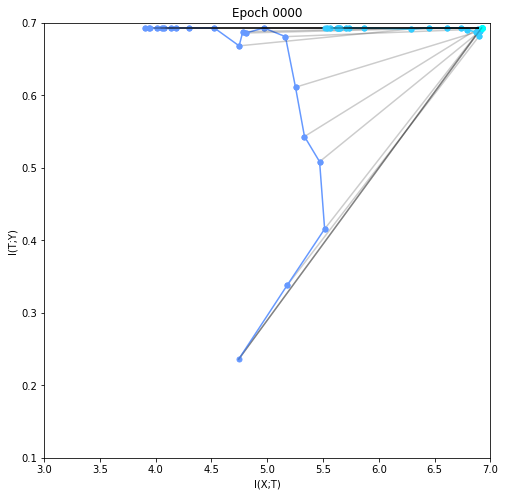

In [100]:
ax.set_title('Epoch 0000 - 2999')
fig # show full evolution process

In [147]:
class Predictor(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes):
        super(Predictor, self).__init__()

        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        
        if n_hidden == []:
            self.layers.append(nn.Linear(self.num_neurons[0], self.num_neurons[1]))
        else:
            for i in range(len(self.num_neurons) - 2):
                self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
                # self.layers.append(nn.LeakyReLU(neg_slope))
                self.layers.append(nn.Tanh())
                #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
                #self.layers['tanh{}'.format(i+1)] = nn.Tanh()
                self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)


            self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out


    
def train_given_z(n_train_samples, exit_layer, num_epochs=2000, dnn_hidden_units=[]):
    
    x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
    x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device), torch.tensor(y_test, requires_grad=False).to(device)

    z_test = torch.tensor(MLP_object(X_test.float(), exitLayer=exit_layer), requires_grad=False).to(device)
    predictor = Predictor(z_test.size(1), dnn_hidden_units, Y_test.size(1)).to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(predictor.parameters(), lr=0.1)#, momentum=0.2)

    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}

    start_time = time.time()
    for epoch in range(num_epochs):
        X_train, Y_train = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)
        z_train = MLP_object(X_train.float(), exitLayer=exit_layer)
        optimizer.zero_grad()
        out =  predictor(z_train.float())
        loss = criterion(out, Y_train.argmax(dim=1))
        loss.backward()
        optimizer.step()
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            accuracy_evaluation['train'].append(accuracy(out, Y_train))
            accuracy_evaluation['test'].append(accuracy(predictor(MLP_object(X_test.float(), exitLayer=exit_layer)), Y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(predictor(z_test.float()), Y_test), criterion(predictor(z_test.float()), Y_test.argmax(dim=1))))
            print('Time after last eval: ', time.time() - start_time)
            print('#'*30,'\n')
    return np.max(accuracy_evaluation['test'])#np.mean(accuracy_evaluation['test'][-5:])

data_step = 5000
acc = {}
num_labels_range = np.arange(10000, n_train_samples+data_step, data_step)
for layer in ['Linear1', 'Linear2']:
    acc[layer] = []
    for num_labels in num_labels_range:
        print('Running for %s %s' % (layer, num_labels))
        acc[layer].append(train_given_z(num_labels, layer, num_epochs=500))

Running for Linear1 10000
##############################
Step -  0
Train: Accuracy - 0.498, Loss - 0.740
Test: Accuracy - 0.498, Loss - 0.733
Time after last eval:  0.007537364959716797
############################## 



/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


##############################
Step -  100
Train: Accuracy - 0.573, Loss - 0.685
Test: Accuracy - 0.586, Loss - 0.685
Time after last eval:  0.3782060146331787
############################## 

##############################
Step -  200
Train: Accuracy - 0.576, Loss - 0.683
Test: Accuracy - 0.587, Loss - 0.682
Time after last eval:  0.6896970272064209
############################## 

##############################
Step -  300
Train: Accuracy - 0.580, Loss - 0.680
Test: Accuracy - 0.589, Loss - 0.679
Time after last eval:  1.0402953624725342
############################## 

##############################
Step -  400
Train: Accuracy - 0.584, Loss - 0.678
Test: Accuracy - 0.590, Loss - 0.677
Time after last eval:  1.3735401630401611
############################## 

##############################
Step -  499
Train: Accuracy - 0.579, Loss - 0.677
Test: Accuracy - 0.587, Loss - 0.675
Time after last eval:  1.7910621166229248
############################## 

Running for Linear1 15000
#########

##############################
Step -  100
Train: Accuracy - 0.550, Loss - 0.691
Test: Accuracy - 0.549, Loss - 0.691
Time after last eval:  1.5768342018127441
############################## 

##############################
Step -  200
Train: Accuracy - 0.573, Loss - 0.686
Test: Accuracy - 0.578, Loss - 0.686
Time after last eval:  3.356574296951294
############################## 

##############################
Step -  300
Train: Accuracy - 0.574, Loss - 0.683
Test: Accuracy - 0.580, Loss - 0.683
Time after last eval:  4.754821300506592
############################## 

##############################
Step -  400
Train: Accuracy - 0.588, Loss - 0.680
Test: Accuracy - 0.590, Loss - 0.680
Time after last eval:  6.143790245056152
############################## 

##############################
Step -  499
Train: Accuracy - 0.593, Loss - 0.678
Test: Accuracy - 0.594, Loss - 0.678
Time after last eval:  7.420387268066406
############################## 

Running for Linear1 50000
#############

##############################
Step -  100
Train: Accuracy - 0.563, Loss - 0.687
Test: Accuracy - 0.563, Loss - 0.687
Time after last eval:  1.366257905960083
############################## 

##############################
Step -  200
Train: Accuracy - 0.567, Loss - 0.685
Test: Accuracy - 0.566, Loss - 0.685
Time after last eval:  2.8408658504486084
############################## 

##############################
Step -  300
Train: Accuracy - 0.569, Loss - 0.684
Test: Accuracy - 0.568, Loss - 0.684
Time after last eval:  4.306330919265747
############################## 

##############################
Step -  400
Train: Accuracy - 0.572, Loss - 0.683
Test: Accuracy - 0.572, Loss - 0.683
Time after last eval:  5.496225833892822
############################## 

##############################
Step -  499
Train: Accuracy - 0.573, Loss - 0.682
Test: Accuracy - 0.573, Loss - 0.682
Time after last eval:  6.53233003616333
############################## 

Running for Linear2 40000
##############

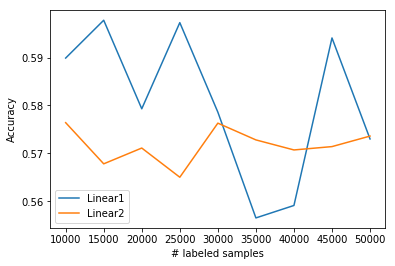

In [148]:
plt.plot(num_labels_range, acc['Linear1'], label='Linear1')
plt.plot(num_labels_range, acc['Linear2'], label='Linear2')
plt.xlabel('# labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

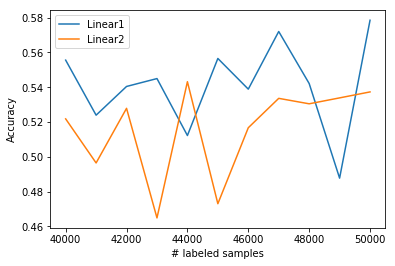

In [145]:
plt.plot(num_labels_range, acc['Linear1'], label='Linear1')
plt.plot(num_labels_range, acc['Linear2'], label='Linear2')
plt.xlabel('# labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()